In [1]:
"""
CS 484 Final Project

Alexander Wei, a6wei@uwaterloo.ca, 20836214
Kaiz Nanji, k4nanji@uwaterloo.ca 20873846

Project #5
Semi-supervised image classification: assuming that only M out of N images in the traingin data have ground truth labels,
design and implement a weakly supervsied training of classification network that can benefit from unlabeled examples in
the training dataset(e.g. MNIST or CIFAR-10, but you need to ignore labels on a subset of training examples).You should
demonstrate how the performance changes as M gets progressively smaller. While you can use any well-motivated ideas, one
basic approach could be to combine cross-entropy on labeled points with (unsupervised) K-means clustering loss over deep
features (e.g. in the last layer before the linear classifier). It is also advisable to use augmentation (a loss
enforcing consistent labeling of augmented training examples). You can also explore Mutual Information loss function
formulated in Bridle & MacKay "Unsupervised Classifiers, Mutual Information and Phantom Targets", NIPS 1991. 
"""

'\nCS 484 Final Project\n\nAlexander Wei, a6wei@uwaterloo.ca, 20836214\nKaiz Nanji\n\nProject #5\nSemi-supervised image classification: assuming that only M out of N images in the traingin data have ground truth labels,\ndesign and implement a weakly supervsied training of classification network that can benefit from unlabeled examples in\nthe training dataset(e.g. MNIST or CIFAR-10, but you need to ignore labels on a subset of training examples).You should\ndemonstrate how the performance changes as M gets progressively smaller. While you can use any well-motivated ideas, one\nbasic approach could be to combine cross-entropy on labeled points with (unsupervised) K-means clustering loss over deep\nfeatures (e.g. in the last layer before the linear classifier). It is also advisable to use augmentation (a loss\nenforcing consistent labeling of augmented training examples). You can also explore Mutual Information loss function\nformulated in Bridle & MacKay "Unsupervised Classifiers, Mutu

In [3]:
from src.encoder import *
from src.k_means import *
from src.loader import *
from src.utils import *

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
from torch.utils.data import DataLoader

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cpu


In [5]:
set_seed()

transform = get_transform()

class ClassificationNetwork:
    def __init__(self, labeled_percent):
        self.labeled_percent = labeled_percent
        self.labeled_train_loader, self.unlabeled_train_loader, self.val_loader = self.get_loaders()

    def get_loaders(self):
        # Increase TRAIN_BATCH_SIZE if you are using GPU to speed up training. 
        # When batch size changes, the learning rate may also need to be adjusted. 
        # Note that batch size maybe limited by your GPU memory, so adjust if you get "run out of GPU memory" error.
        TRAIN_BATCH_SIZE = 100

        # If you are NOT using Windows, set NUM_WORKERS to anything you want, e.g. NUM_WORKERS = 4,
        # but Windows has issues with multi-process dataloaders, so NUM_WORKERS must be 0 for Windows.
        NUM_WORKERS = 0

        dataset_handler = LabeledUnlabeledMNIST(self.labeled_percent)
        labeled_train = dataset_handler.labeled_dataset
        unlabeled_train = dataset_handler.unlabeled_dataset
        mnist_test = dataset_handler.mnist_test

        self.VALIDATION_SIZE = len(mnist_test)

        labeled_train_loader = DataLoader(labeled_train, batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)
        unlabeled_train_loader = DataLoader(unlabeled_train, batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)
        val_loader = DataLoader(mnist_test, batch_size=len(mnist_test), num_workers=NUM_WORKERS, shuffle=False)

        return labeled_train_loader, unlabeled_train_loader, val_loader

    def train(self):
        %run -i 'run.py' encoder '{self.labeled_percent}' -t

    def get_encodes_targets(self, loader, encoder_model):
        encodes = None
        targets = None

        with torch.no_grad():
            for batch_id, (data, target) in enumerate(loader):
                data = data.to(device)
                encoded = encoder_model.encode(data)

                if batch_id == 0:
                    encodes = encoded
                    targets = target
                else:
                    encodes = torch.cat((encodes, encoded))
                    targets = torch.cat((targets, target))
        
        return encodes, targets

    def run_kmeans(self):
        k_means = KMeansModel(tensor_dims=256)

        encoder_model = EncoderModel(device, None)
        encoder_model.load_state_dict(torch.load("./saves/encoder_model_{}.pth".format(str(self.labeled_percent)[2:])))
        encoder_model = encoder_model.to(device)

        encoder_model.train(False)

        labeled_encodes, labeled_targets = self.get_encodes_targets(self.labeled_train_loader, encoder_model)
        unlabeled_encodes, unlabeled_targets = self.get_encodes_targets(self.unlabeled_train_loader, encoder_model)

        k_means.fit(labeled_encodes, labeled_targets, unlabeled_encodes)
        
        val_data, val_labels = next(iter(self.val_loader))
        encoded_val_data = encoder_model.encode(val_data.to(device))

        predictions = k_means.predict(encoded_val_data)

        confusion_matrix = np.zeros((10, 10))
        for label, pred in zip(val_labels, predictions):
            confusion_matrix[label, pred] += 1

        accuracy = sum([confusion_matrix[i][i] for i in range(10)]) / self.VALIDATION_SIZE
        print(f"Accuracy: {accuracy * 100}%")

        disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[i for i in range(10)])
        disp.plot()
        plt.title("K Means Classifier Confusion Matrix")
        plt.show()


cpu
Loss at epoch 0: 0.331368625164032
Loss at epoch 1: 0.25608575344085693
Loss at epoch 2: 0.22751359641551971
Loss at epoch 3: 0.2160346508026123
Loss at epoch 4: 0.20424294471740723
Completed training! Final loss: 0.20424294471740723
Running validation...


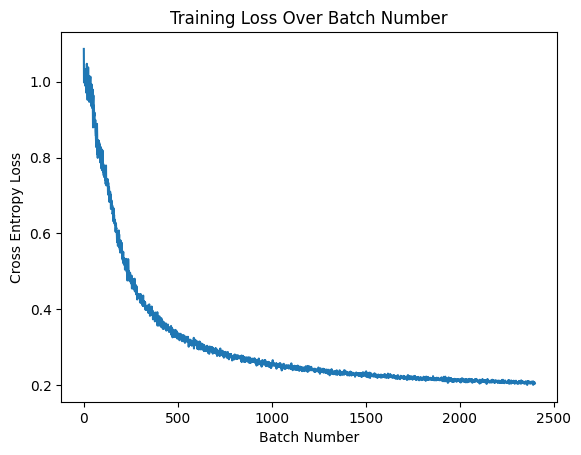

Saving model...
Accuracy: 55.779999999999994%


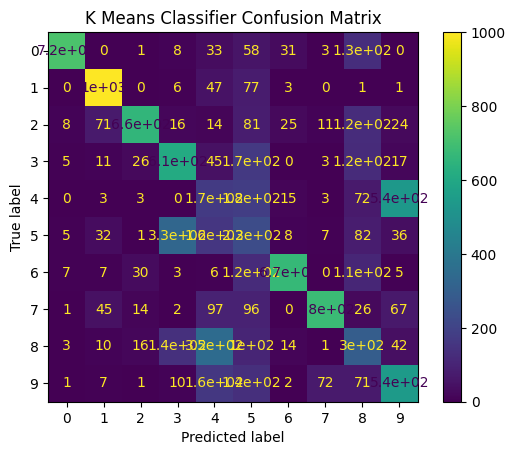

In [7]:
network = ClassificationNetwork(0.8)
network.train()
network.run_kmeans()

cpu
Loss at epoch 0: 0.42192625999450684
Loss at epoch 1: 0.3067528307437897
Loss at epoch 2: 0.2690245807170868
Loss at epoch 3: 0.24817495048046112
Loss at epoch 4: 0.22695741057395935
Completed training! Final loss: 0.22695741057395935
Running validation...


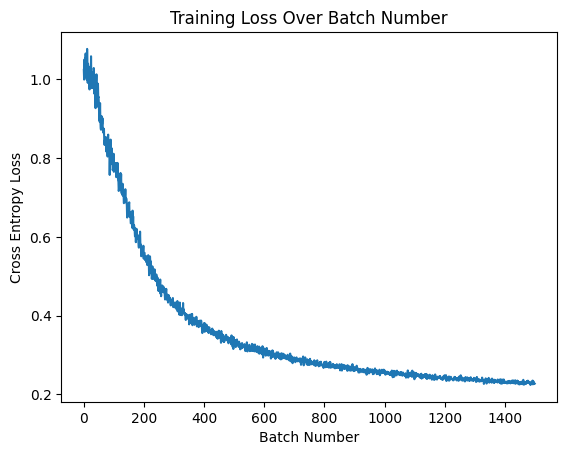

Saving model...
Accuracy: 54.36%


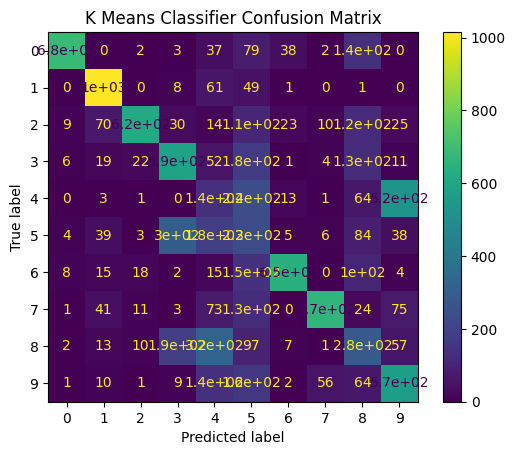

In [8]:
network = ClassificationNetwork(0.5)
network.train()
network.run_kmeans()

cpu
Loss at epoch 0: 0.7539397478103638
Loss at epoch 1: 0.48524513840675354
Loss at epoch 2: 0.38814905285835266
Loss at epoch 3: 0.347412645816803
Loss at epoch 4: 0.29998621344566345
Completed training! Final loss: 0.29998621344566345
Running validation...


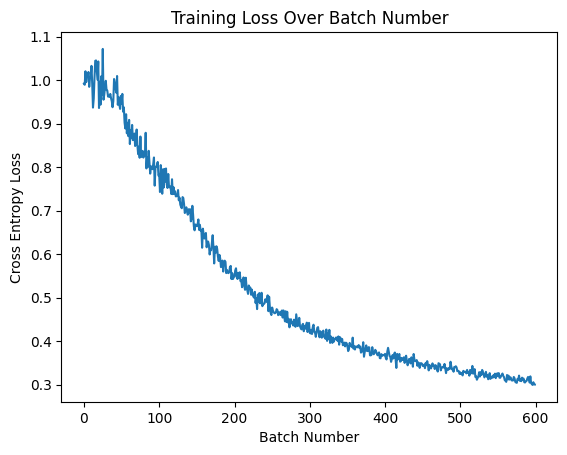

Saving model...
Accuracy: 55.05%


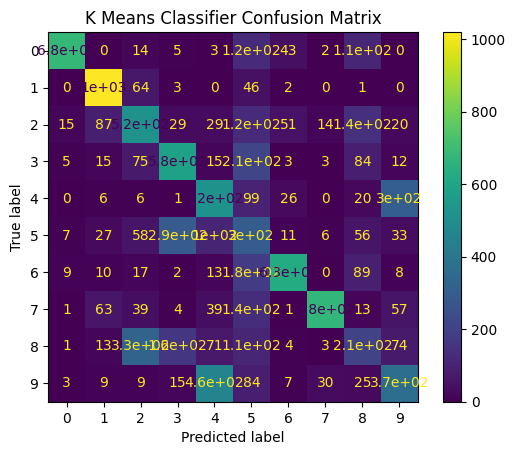

In [9]:
network = ClassificationNetwork(0.2)
network.train()
network.run_kmeans()

cpu
Loss at epoch 0: 1.0189646482467651
Loss at epoch 1: 1.014025330543518
Loss at epoch 2: 0.9849284291267395
Loss at epoch 3: 0.9762715101242065
Loss at epoch 4: 1.0400639772415161
Completed training! Final loss: 1.0400639772415161
Running validation...


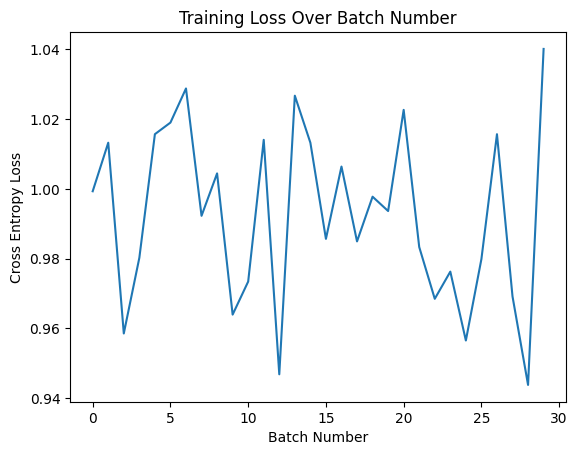

Saving model...
Accuracy: 37.64%


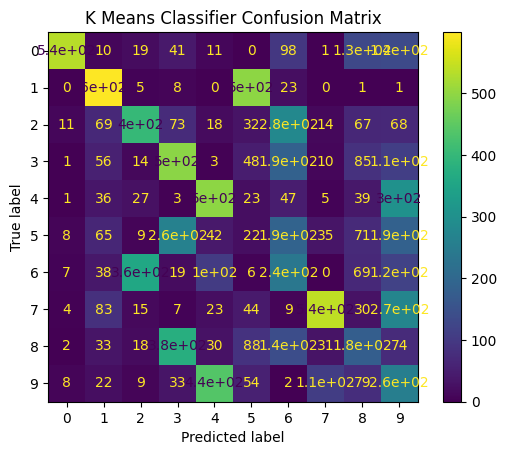

In [10]:
network = ClassificationNetwork(0.01)
network.train()
network.run_kmeans()

In [5]:
# # Increase TRAIN_BATCH_SIZE if you are using GPU to speed up training. 
# # When batch size changes, the learning rate may also need to be adjusted. 
# # Note that batch size maybe limited by your GPU memory, so adjust if you get "run out of GPU memory" error.
# TRAIN_BATCH_SIZE = 100

# # If you are NOT using Windows, set NUM_WORKERS to anything you want, e.g. NUM_WORKERS = 4,
# # but Windows has issues with multi-process dataloaders, so NUM_WORKERS must be 0 for Windows.
# NUM_WORKERS = 0


# labeled_train_loader = DataLoader(labeled_train, batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)
# unlabeled_train_loader = DataLoader(unlabeled_train, batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)
# val_loader = DataLoader(mnist_test, batch_size=len(mnist_test), num_workers=NUM_WORKERS, shuffle=False)

In [6]:
# # Dimension of encoder output is N * 64 * 2 * 2 = 256

# k_means = KMeansModel(tensor_dims=256)

# encoder_model = EncoderModel(device, None)
# encoder_model.load_state_dict(torch.load("./saves/encoder_model_8.pth"))
# encoder_model = encoder_model.to(device)

In [7]:
# encoder_model.train(False)

# labeled_encodes = None
# labeled_targets = None

# with torch.no_grad():
#   for batch_id, (data, target) in enumerate(labeled_train_loader):
    
#     data = data.to(device)

#     encoded = encoder_model.encode(data)

#     if batch_id == 0:
#       labeled_encodes = encoded
#       labeled_targets = target
#     else:
#       labeled_encodes = torch.cat((labeled_encodes, encoded))
#       labeled_targets = torch.cat((labeled_targets, target))

# print(labeled_targets)

tensor([5, 0, 5,  ..., 3, 0, 8])


In [8]:
# unlabeled_encodes = None
# unlabeled_targets = None

# with torch.no_grad():
#   for batch_id, (data, target) in enumerate(unlabeled_train_loader):
    
#     data = data.to(device)

#     encoded = encoder_model.encode(data)

#     if batch_id == 0:
#       unlabeled_encodes = encoded
#       unlabeled_targets = target
#     else:
#       unlabeled_encodes = torch.cat((unlabeled_encodes, encoded))
#       unlabeled_targets = torch.cat((unlabeled_targets, target))

# print(unlabeled_targets.shape)

torch.Size([12000])


In [9]:
# k_means.fit(labeled_encodes, labeled_targets, unlabeled_encodes)

Accuracy: 62.470000000000006%


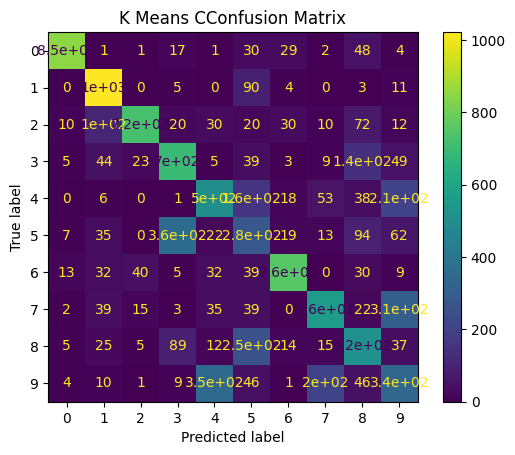

In [10]:
# VALIDATION_SIZE = len(mnist_test)

# val_data, val_labels = next(iter(val_loader))
# encoded_val_data = encoder_model.encode(val_data.to(device))

# predictions = k_means.predict(encoded_val_data)

# confusion_matrix = np.zeros((10, 10))
# for label, pred in zip(val_labels, predictions):
#   confusion_matrix[label, pred] += 1

# accuracy = sum([confusion_matrix[i][i] for i in range(10)]) / VALIDATION_SIZE
# print(f"Accuracy: {accuracy * 100}%")

# disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[i for i in range(10)])
# disp.plot()
# plt.title("K Means Classifier Confusion Matrix")
# plt.show()